In [17]:
# !pip install pandas
# !pip install matplotlib
# %pip install numpy
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

Note: you may need to restart the kernel to use updated packages.


Starten met exploreren en importeren van data

In [4]:

#base_path = 'C:/GitHub/Data-Analytics-Case-2_LOCAL/data/'
base_path = 'data/'
# Reading data.csv with consideration for mixed types
data = pd.read_csv(base_path + 'data.csv', sep=',', low_memory=False)
# Reading holidays_events.csv without specific issues mentioned, but keep an eye for potential encoding errors
holidays_events = pd.read_csv(base_path + 'holidays_events(India).csv', sep=';')
# Reading items.csv with consideration for mixed types
items = pd.read_csv(base_path + 'items.csv', sep=';', low_memory=False)
# Reading oil.csv, noting there might be lines with missing data (';;')
oil = pd.read_csv(base_path + 'oil(India).csv', sep=',', skipinitialspace=True)
# Reading stores.csv with specified encoding to address potential UnicodeDecodeError
stores = pd.read_csv(base_path + 'stores.csv', sep=';', encoding='ISO-8859-1')
# Reading test.csv without specific issues mentioned
test = pd.read_csv(base_path + 'test.csv', sep=',')
# Reading transactions.csv without specific issues mentioned
transactions = pd.read_csv(base_path + 'transactions.csv', sep=',')

# Notes:
# 1. For files like 'oil(India).csv' where there are potential empty fields (';;'), skipinitialspace=True helps clean up any leading spaces after the separator, which might help in correctly parsing the fields.
# 2. If any of these files still present challenges, consider specifying dtype for columns with mixed types, or exploring the files manually to identify further specific needs (like missing values handling, encoding, etc.).
print(data.head())
print(holidays_events.head())
print(items.head())
print(oil.head())
print(stores.head())
print(test.head())
print(transactions.head())

   Unnamed: 0   id        date  store_nbr  item_nbr  unit_sales onpromotion
0           0    0  2013-01-01         25    103665         7.0         NaN
1          60   60  2013-01-01         25    214381         5.0         NaN
2         120  120  2013-01-01         25    315179         4.0         NaN
3         180  180  2013-01-01         25    414752         1.0         NaN
4         240  240  2013-01-01         25    557408         3.0         NaN
     date       type                description         transferred
0   1/jan     zondag             New Year's Day  Restricted Holiday
1   5/jan  donderdag  Guru Govind Singh Jayanti          Observance
2  14/jan   zaterdag                     Pongal  Restricted Holiday
3  15/jan     zondag            Makar Sankranti  Restricted Holiday
4  23/jan    maandag           Chinese New Year          Observance
   item_nbr      family   class  perishable      Price
0  121964.0  AUTOMOTIVE  6810.0         0.0  38.604012
1  172995.0  AUTOMOTIVE  6

iedere file appart pre-processing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB
Original DataFrame shape: (3370464, 5)
DataFrame shape after removing outliers: (3370464, 5)


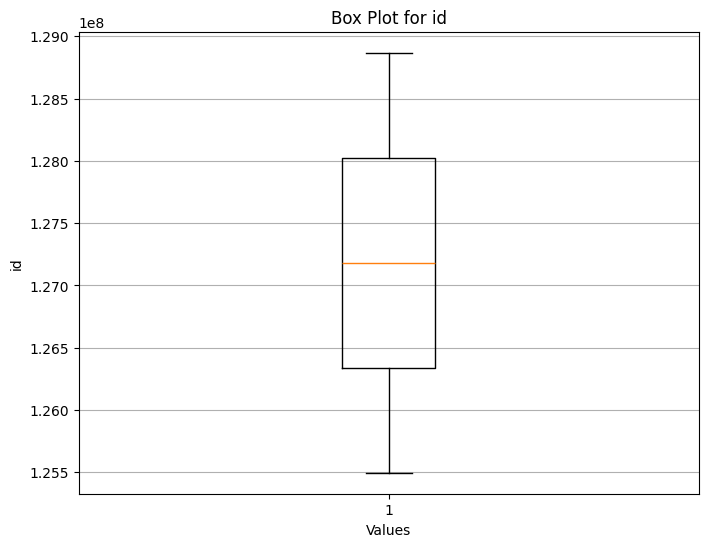

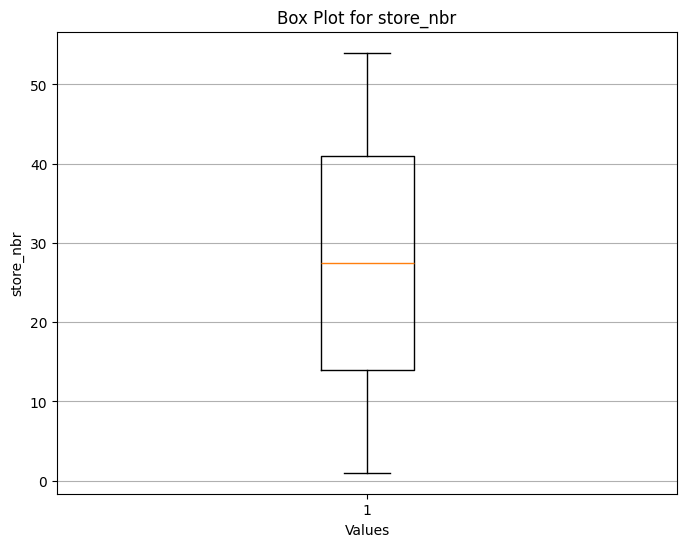

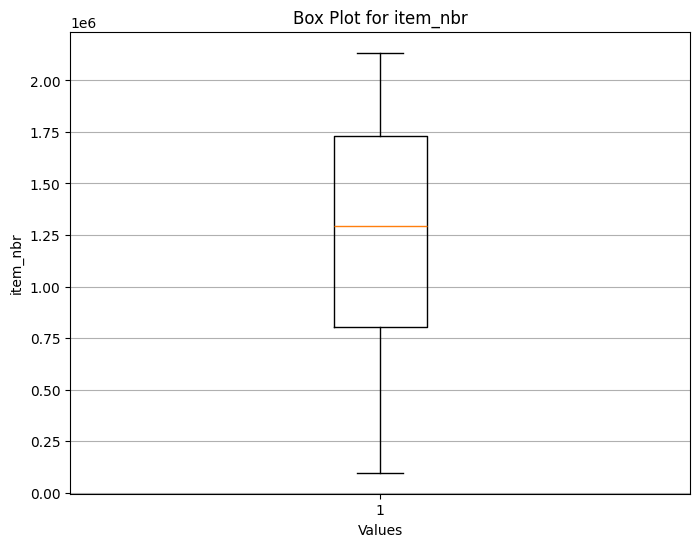

In [6]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test.info()
test.head()

# Assuming 'test' is your DataFrame
# Select only the numeric columns (excluding 'date' and 'onpromotion')
numeric_columns = ['id', 'store_nbr', 'item_nbr']

# Calculate the IQR for each numeric column
Q1 = test[numeric_columns].quantile(0.25)
Q3 = test[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outlier indices using Boolean arrays
outlier_indices = ((test[numeric_columns] < (Q1 - 1.5 * IQR)) | (test[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Create a new DataFrame without outliers
df_no_outliers = test[~outlier_indices]

print("Original DataFrame shape:", test.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

# Create a separate box plot for each numeric column
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(test[col])
    plt.title(f"Box Plot for {col}")
    plt.xlabel("Values")
    plt.ylabel(col)
    plt.grid(axis='y')
    plt.show()



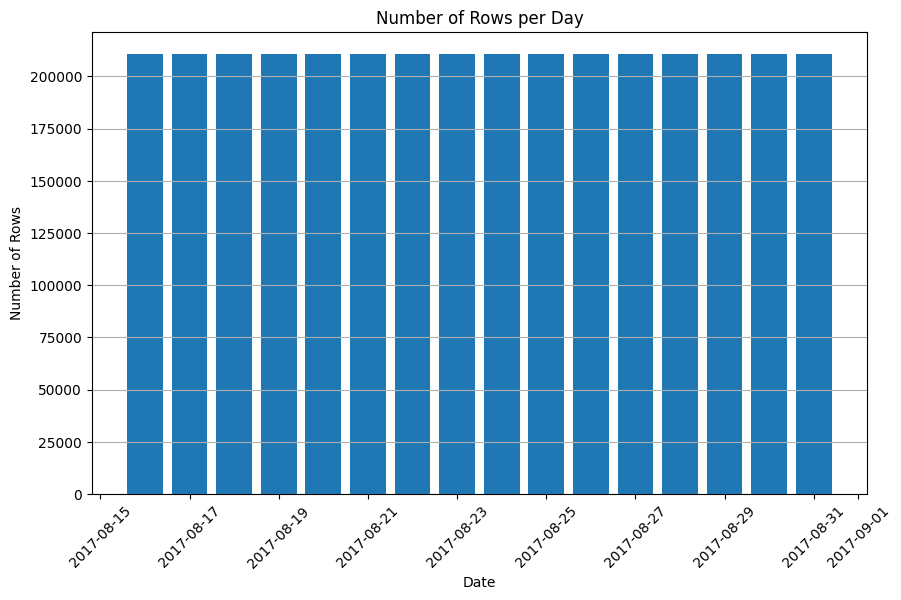

In [9]:
# Group by date and count the number of rows per day
daily_counts = test.groupby(test['date'].dt.date).size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values) # type: ignore
plt.title("Number of Rows per Day")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y')
plt.show()

Het ziet er dus naar uit dat we consistente data hebben in deze file

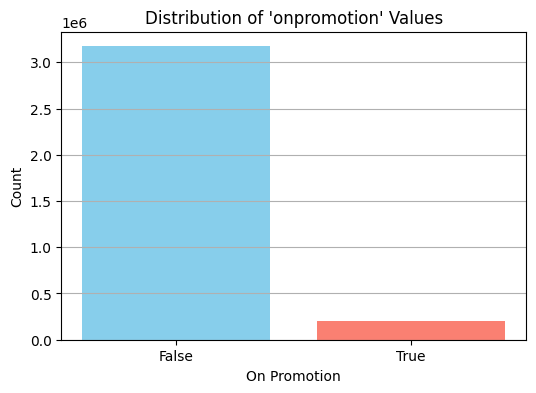

onpromotion
False    3171867
True      198597
Name: count, dtype: int64


In [14]:
# Create a count of True and False values
promotion_counts = test['onpromotion'].value_counts()

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(promotion_counts.index, promotion_counts.values, color=['skyblue', 'salmon']) # type: ignore
plt.title("Distribution of 'onpromotion' Values")
plt.xlabel("On Promotion")
plt.ylabel("Count")
plt.xticks([0, 1], ['False', 'True'])  # Set x-axis labels
plt.grid(axis='y')
plt.show()

print(promotion_counts)

In [10]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


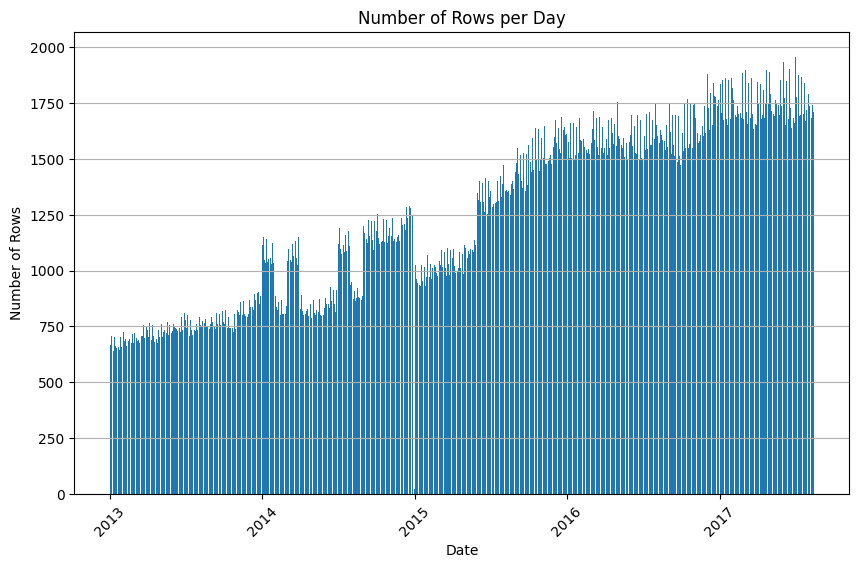

In [15]:
# Group by date and count the number of rows per day
daily_counts = data.groupby(data['date'].dt.date).size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values) # type: ignore
plt.title("Number of Rows per Day")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y')
plt.show()